Notebook adapted from https://www.kaggle.com/bguberfain/naive-keras

Setup the kernel

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skimage.io import imread
from skimage.transform import downscale_local_mean
from os.path import join
from tqdm.notebook import tqdm
import cv2
from sklearn.model_selection import train_test_split
import tensorflow as tf
import tensorflow_addons as tfa
import os
from tensorflow.keras.preprocessing.image import array_to_img, img_to_array, load_img, ImageDataGenerator

In [3]:
input_folder = 'G:/Github/Caravan_challenge/data/'

df_mask = pd.read_csv(join(input_folder, 'train_masks.csv'), usecols=['img'])
ids_train = df_mask['img'].map(lambda s: s.split('_')[0]).unique()

imgs_idx = list(range(1, 17))

Setup data input

In [28]:
load_img = lambda im, idx: imread(join(input_folder, 'train', '{}_{:02d}.jpg'.format(im, idx)))
load_mask = lambda im, idx: imread(join(input_folder, 'train_masks', '{}_{:02d}_mask.gif'.format(im, idx)))
resize = lambda im: downscale_local_mean(im, (4,4) if im.ndim==2 else (4,4,1))
mask_image = lambda im, mask: (im * np.expand_dims(mask, 2))

In [33]:
num_train = 32  # len(ids_train)

# Load data for position id=1
X = np.empty((num_train, 320, 480, 9), dtype=np.float32)
y = np.empty((num_train, 320, 480, 1), dtype=np.float32)

with tqdm(total=num_train) as bar:
    idx = 1 # Rotation index
    for i, img_id in enumerate(ids_train[:num_train]):
        imgs_id = [resize(load_img(img_id, j)) for j in imgs_idx]
        # Input is image + mean image per channel + std image per channel
        X[i, ..., :9] = np.concatenate([imgs_id[idx-1], np.mean(imgs_id, axis=0), np.std(imgs_id, axis=0)], axis=2)
        y[i] = resize(np.expand_dims(load_mask(img_id, idx), 2)) / 255.
        #del imgs_id # Free memory
        bar.update()

In [34]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=0)

In [35]:
# Normalize input and output
X_mean = X_train.mean(axis=(0,1,2), keepdims=True)
X_std = X_train.std(axis=(0,1,2), keepdims=True)

X_train -= X_mean
X_train /= X_std

X_val -= X_mean
X_val /= X_std

In [36]:
X_train

array([[[[ 1.0754572 ,  1.1012752 ,  1.147154  , ..., -0.76469123,
          -0.76076496, -0.74252385],
         [ 1.0754572 ,  1.1012752 ,  1.147154  , ..., -0.76469123,
          -0.76076496, -0.74252385],
         [ 1.0401087 ,  1.066062  ,  1.1118281 , ..., -0.7532048 ,
          -0.7507229 , -0.74123776],
         ...,
         [ 1.0401087 ,  1.066062  ,  1.1118281 , ..., -0.75004876,
          -0.7586183 , -0.7811328 ],
         [ 1.0401087 ,  1.066062  ,  1.1118281 , ..., -0.755843  ,
          -0.76436067, -0.78707266],
         [-1.0808063 , -1.0467333 , -1.0077282 , ..., -0.7745704 ,
          -0.78292036, -0.8062707 ]],

        [[ 1.0754572 ,  1.1012752 ,  1.147154  , ..., -0.76469123,
          -0.76076496, -0.74252385],
         [ 1.0754572 ,  1.1012752 ,  1.147154  , ..., -0.76469123,
          -0.76076496, -0.74252385],
         [ 1.0401087 ,  1.066062  ,  1.1118281 , ..., -0.7532048 ,
          -0.7507229 , -0.74123776],
         ...,
         [ 1.0401087 ,  1.066062  

Define our own dice_coef (F1) for the images

In [40]:
# Now let's use Tensorflow to write our own dice_coeficcient metric
from tensorflow.keras.backend import flatten
import tensorflow.keras.backend as K
from tensorflow.keras.losses import BinaryCrossentropy

smooth = 1.
def dice_coef(y_true, y_pred):
    y_true_f = flatten(y_true)
    y_pred_f = flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)


Set up a simple CNN model

In [41]:
from tensorflow.keras.layers import Conv2D
from tensorflow.keras import Sequential


model = Sequential()
model.add( Conv2D(16, 3, activation='relu', padding='same', input_shape=(320, 480, 9)) )
model.add( Conv2D(32, 3, activation='relu', padding='same') )
model.add( Conv2D(1, 5, activation='sigmoid', padding='same') )

Complile model

In [43]:
model.compile(optimizer = 'Adam', loss = BinaryCrossentropy(), metrics=['accuracy',dice_coef])

In [44]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 320, 480, 16)      1312      
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 320, 480, 32)      4640      
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 320, 480, 1)       801       
Total params: 6,753
Trainable params: 6,753
Non-trainable params: 0
_________________________________________________________________


In [45]:
# Include the epoch in the file name (uses `str.format`)
checkpoint_path = "G:/Github/Caravan_challenge/training_tf/naive_org/cp-{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights every 5 epochs
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path, 
    verbose=1, 
    save_weights_only=False,
    save_freq='epoch')

In [46]:
model.fit(X_train, y_train, epochs=15, validation_data=(X_val, y_val), batch_size=5, verbose=2)

Train on 25 samples, validate on 7 samples
Epoch 1/15
25/25 - 9s - loss: 0.6382 - accuracy: 0.6944 - dice_coef: 0.2349 - val_loss: 0.5217 - val_accuracy: 0.8310 - val_dice_coef: 0.2755
Epoch 2/15
25/25 - 8s - loss: 0.4309 - accuracy: 0.8680 - dice_coef: 0.3204 - val_loss: 0.3561 - val_accuracy: 0.8692 - val_dice_coef: 0.4614
Epoch 3/15
25/25 - 8s - loss: 0.3147 - accuracy: 0.8890 - dice_coef: 0.4375 - val_loss: 0.2929 - val_accuracy: 0.8936 - val_dice_coef: 0.5221
Epoch 4/15
25/25 - 9s - loss: 0.2729 - accuracy: 0.8994 - dice_coef: 0.5014 - val_loss: 0.2614 - val_accuracy: 0.8928 - val_dice_coef: 0.5919
Epoch 5/15
25/25 - 9s - loss: 0.2550 - accuracy: 0.8961 - dice_coef: 0.5432 - val_loss: 0.2469 - val_accuracy: 0.9037 - val_dice_coef: 0.5782
Epoch 6/15
25/25 - 9s - loss: 0.2420 - accuracy: 0.9059 - dice_coef: 0.5314 - val_loss: 0.2299 - val_accuracy: 0.9093 - val_dice_coef: 0.6033
Epoch 7/15
25/25 - 9s - loss: 0.2299 - accuracy: 0.9042 - dice_coef: 0.5739 - val_loss: 0.2178 - val_accu

Text(0, 0.5, 'Loss')

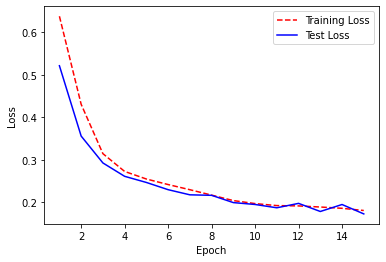

In [47]:
training_loss = model.history.history['loss']
test_loss = model.history.history['val_loss']

# Create count of the number of epochs
epoch_count = range(1, len(training_loss) + 1)

# Visualize loss history
plt.plot(epoch_count, training_loss, 'r--')
plt.plot(epoch_count, test_loss, 'b-')
plt.legend(['Training Loss', 'Test Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')

Text(0, 0.5, 'Accuracy')

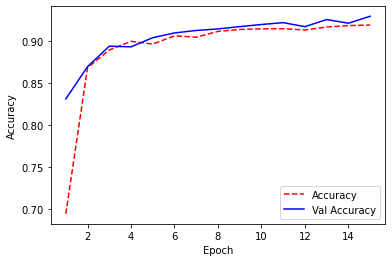

In [48]:
training_loss = model.history.history['accuracy']
test_loss = model.history.history['val_accuracy']

# Create count of the number of epochs
epoch_count = range(1, len(training_loss) + 1)

# Visualize loss history
plt.plot(epoch_count, training_loss, 'r--')
plt.plot(epoch_count, test_loss, 'b-')
plt.legend(['Accuracy', 'Val Accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')